# **Understanding and Utilizing the Detectron2 Framework for Object Detection Tasks:**

## **Phase 1: Setup and Data Exploration**

In [1]:
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15837, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 15837 (delta 35), reused 14 (delta 14), pack-reused 15772 (from 2)
Receiving objects: 100% (15837/15837), 6.41 MiB | 6.85 MiB/s, done.
Resolving deltas: 100% (11533/11533), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't match your en

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.5 ; cuda:  cu124
detectron2: 0.6


In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

In [4]:

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from detectron2.structures import BoxMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode

In [5]:
# Dataset downloading
!gdown 1YVBGMru0dlwB8zu1OoErOazZoc8ISSJn

Downloading...
From (original): https://drive.google.com/uc?id=1YVBGMru0dlwB8zu1OoErOazZoc8ISSJn
From (redirected): https://drive.google.com/uc?id=1YVBGMru0dlwB8zu1OoErOazZoc8ISSJn&confirm=t&uuid=07184037-3193-42d7-ad25-62fea066e160
To: /content/LV-MHP-v2.zip
100% 5.43G/5.43G [01:13<00:00, 73.8MB/s]


In [6]:
# Dataset extraction
!jar xf /content/LV-MHP-v2.zip

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [8]:
# Copy the provided annotation files
import shutil
source_path = '/content/drive/MyDrive/Colab/train/data_list.json'
destination_path = '/content/LV-MHP-v2/train'
shutil.copy(source_path, destination_path)

source_path = '/content/drive/MyDrive/Colab/val/data_list.json'
destination_path = '/content/LV-MHP-v2/val'
shutil.copy(source_path, destination_path)

'/content/LV-MHP-v2/val/data_list.json'

In [9]:
class_ids = {
    "person": 0
}

def get_LVMHPV2_dicts(img_dir):
    json_file = os.path.join(img_dir, "data_list.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    reduced_img_dir = "/".join(img_dir.split("/")[:-1])+"/"
    dataset_dicts = []
    print(len(imgs_anns))
    for idx, v in enumerate(imgs_anns):
        record = {}

        try:
            filename = os.path.join(reduced_img_dir, v['filepath'].split(
                '/home/notebook/code/personal/S9043252/Parsing-R-CNN/data/LV-MHP-v2/')[1])
            height, width = cv2.imread(filename).shape[:2]
        except:
            continue

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        objs = []
        for box in v["bboxes"]:

            obj = {
                "bbox": [box["x1"], box["y1"], box["x2"], box["y2"]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": class_ids[box["class"]],
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [10]:
dataset_dicts = get_LVMHPV2_dicts("/content/LV-MHP-v2/val")
dataset_dicts = get_LVMHPV2_dicts("/content/LV-MHP-v2/train")

for d in ["train", "val"]:
    DatasetCatalog.register("LVMHPV2_" + d, lambda d=d: get_LVMHPV2_dicts("/content/LV-MHP-v2/" + d))
    MetadataCatalog.get("LVMHPV2_" + d).set(thing_classes=["person"])
LVMHP_meta = MetadataCatalog.get("LVMHPV2_train")

4999
15403


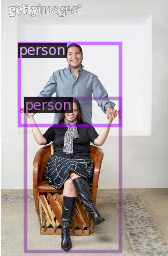

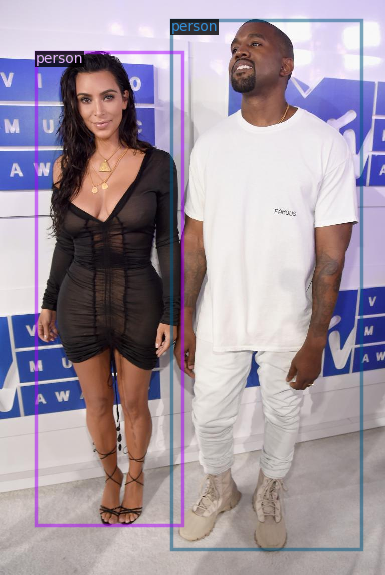

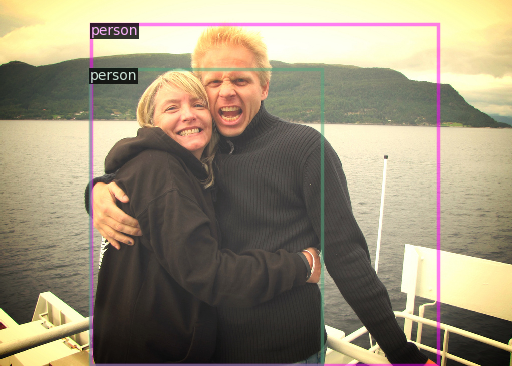

In [ ]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=LVMHP_meta, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.waitKey(0)

In [ ]:
def get_annotation_files(image_id, parsing_annotations_dir):
    annotation_files = [f for f in os.listdir(parsing_annotations_dir) if f.startswith(image_id)]
    annotation_paths = [os.path.join(parsing_annotations_dir, f) for f in annotation_files]
    return annotation_paths

In [ ]:
def visualize_parsing_annotations(img_path,parsing_annotations_dir):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get annotation masks
    image_id = os.path.splitext(os.path.basename(img_path))[0]
    annotation_paths = get_annotation_files(image_id, parsing_annotations_dir)

    combined_mask = None

    for anno_path in annotation_paths:
        mask = cv2.imread(anno_path, cv2.IMREAD_UNCHANGED)
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))  # Resize mask to match image

        if combined_mask is None:
            combined_mask = mask
        else:
            combined_mask = np.maximum(combined_mask, mask)

    if combined_mask.ndim == 3 and combined_mask.shape[2] == 4:
        combined_mask = combined_mask[:, :, 2]

    if combined_mask.max() > 1:
        combined_mask = (combined_mask / combined_mask.max()) * 255

    combined_mask = combined_mask.astype(np.uint8)
    colored_mask = cv2.applyColorMap(combined_mask, cv2.COLORMAP_JET)

    # Create an alpha mask where background
    # Back ground color [0,0,0]
    alpha_mask = np.where(combined_mask > 0, 1, 0).astype(np.uint8)[:, :, None]
    output_image = img.copy()
    output_image = cv2.addWeighted(output_image, 0.7, colored_mask * alpha_mask, 0.3, 0)

    cv2_imshow(output_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


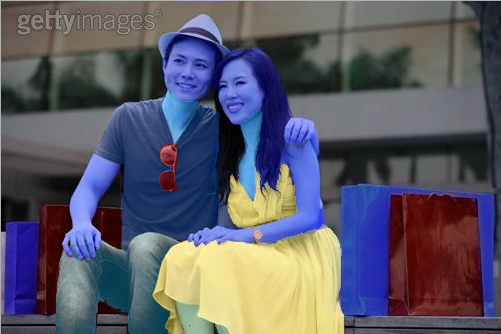

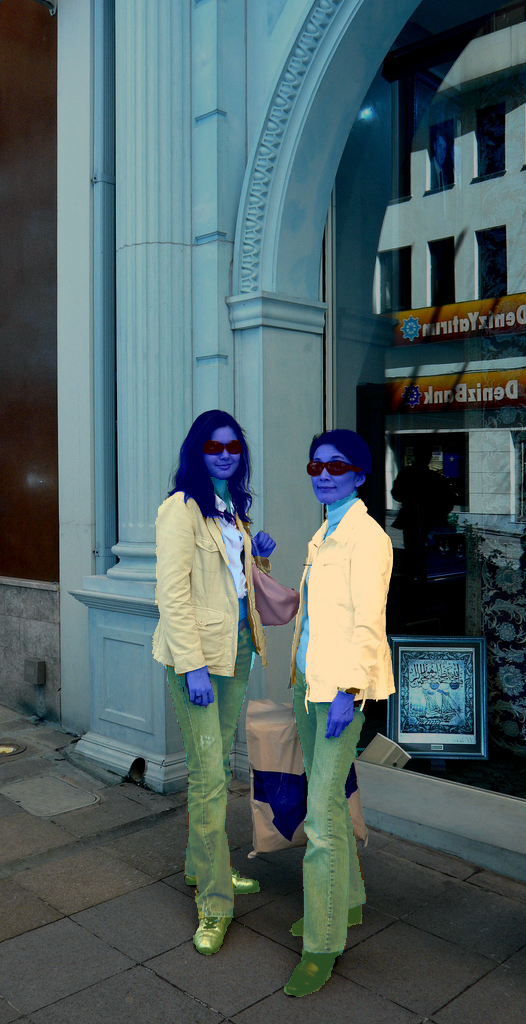

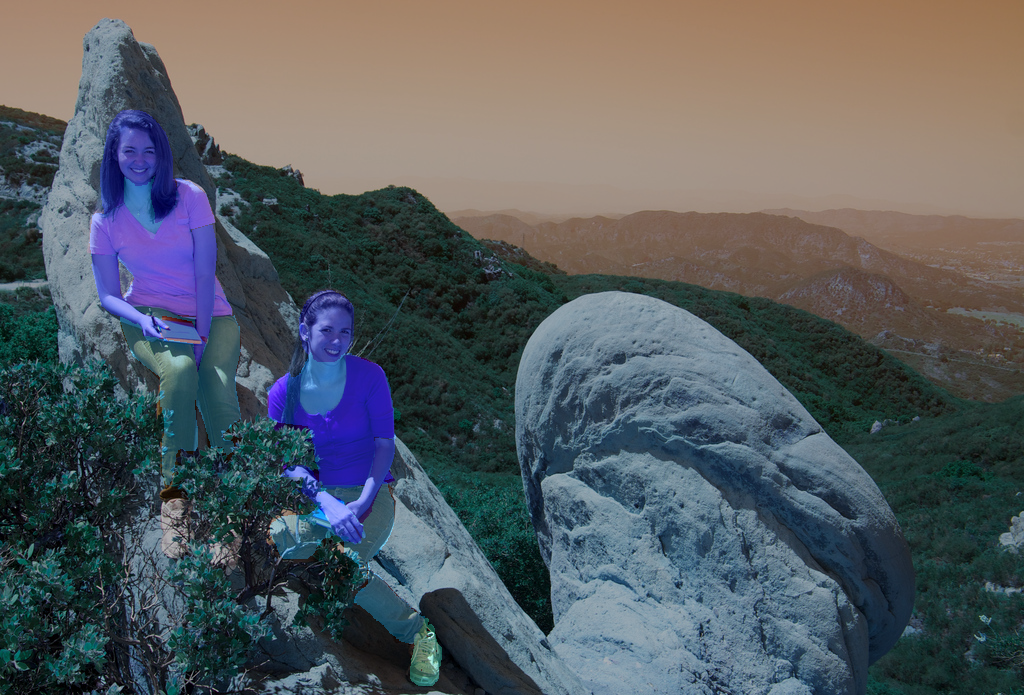

In [ ]:
parsing_annotations_dir = "/content/LV-MHP-v2/train/parsing_annos"

for d in random.sample(dataset_dicts, 3):
    img_path = d["file_name"]
    visualize_parsing_annotations(img_path, parsing_annotations_dir)

In [ ]:
def get_pose_file(image_id, pose_dir):
    pose_file = os.path.join(pose_dir, f"{image_id}.mat")
    return pose_file

In [ ]:
import scipy.io

def visualize_pose_annotations(image_path, pose_annotations_dir):
    image = cv2.imread(image_path)
    image_id = os.path.splitext(os.path.basename(image_path))[0]
    pose_file = get_pose_file(image_id, pose_annotations_dir)

    # Load the pose annotations from the MATLAB file
    pose_data = scipy.io.loadmat(pose_file)

    # Define keypoints pairs to connect
    keypoint_pairs = [
        ("right_ankle", "right_knee"), ("right_knee", "right_hip"), ("right_hip", "pelvis"),
        ("pelvis", "left_hip"), ("left_hip", "left_knee"), ("left_knee", "left_ankle"),
        ("pelvis", "thorax"), ("thorax", "upper_neck"), ("upper_neck", "head_top"),("upper_neck", "right_shoulder"),
        ("upper_neck", "left_shoulder"),("right_shoulder", "right_elbow"), ("right_elbow", "right_wrist"),
        ("left_shoulder", "left_elbow"), ("left_elbow", "left_wrist"),
        # Add any other relevant pairs here
    ]

    # Iterate through the keys in the MATLAB file
    for key in pose_data:
        if key.startswith('person_'):  # Filter keys for persons
            person_data = pose_data[key]

            # From https://lv-mhp.github.io/pose_estimation_task
            keypoints = {
                "right_ankle": person_data[0],
                "right_knee": person_data[1],
                "right_hip": person_data[2],
                "left_hip": person_data[3],
                "left_knee": person_data[4],
                "left_ankle": person_data[5],
                "pelvis": person_data[6],
                "thorax": person_data[7],
                "upper_neck": person_data[8],
                "head_top": person_data[9],
                "right_wrist": person_data[10],
                "right_elbow": person_data[11],
                "right_shoulder": person_data[12],
                "left_shoulder": person_data[13],
                "left_elbow": person_data[14],
                "left_wrist": person_data[15]
            }

            # Plot keypoints and connect them based on pairs
            for point_name, (x, y, visibility) in keypoints.items():
                if x >= 0 and y >= 0:
                    color = (0, 0, 255)
                    cv2.circle(image, (int(x), int(y)), 5, color, -1)

            # Connect the points based on predefined pairs
            for start_name, end_name in keypoint_pairs:
                if start_name in keypoints and end_name in keypoints:
                    x_start, y_start, _ = keypoints[start_name]
                    x_end, y_end, _ = keypoints[end_name]

                    if x_start >= 0 and y_start >= 0 and x_end >= 0 and y_end >= 0:
                        cv2.line(image, (int(x_start), int(y_start)), (int(x_end), int(y_end)), (0, 255, 0), 2)

    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Processing image: /content/LV-MHP-v2/train/images/17750.jpg


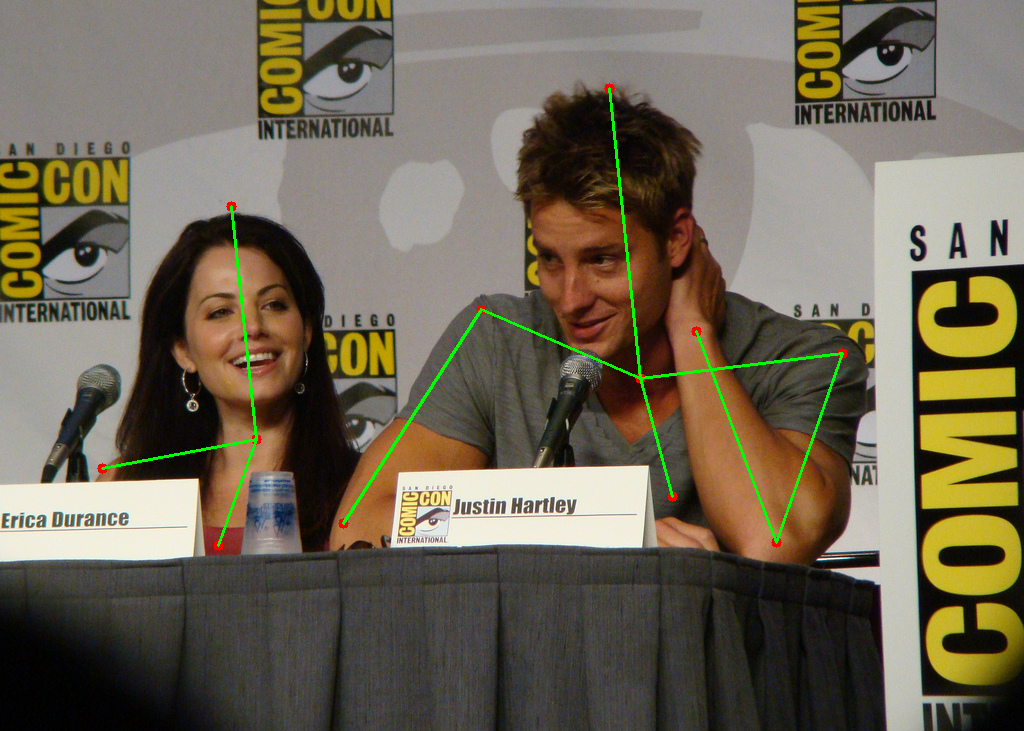

Processing image: /content/LV-MHP-v2/train/images/6967.jpg


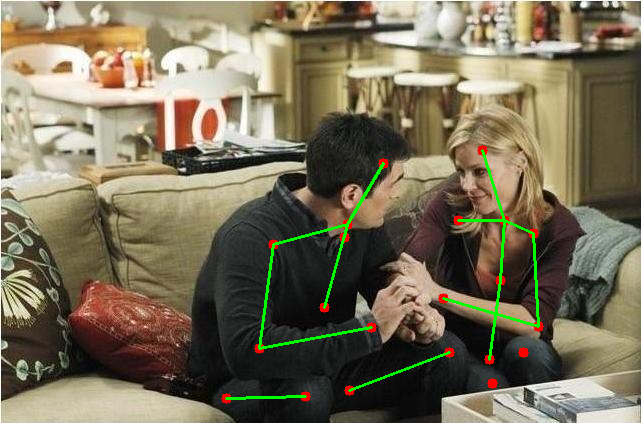

Processing image: /content/LV-MHP-v2/train/images/9087.jpg


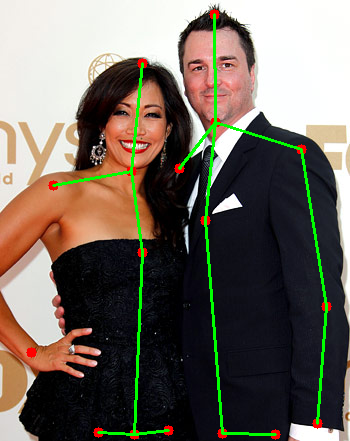

In [ ]:
pose_annotations_dir = "/content/LV-MHP-v2/train/pose_annos"

for d in random.sample(dataset_dicts, 3):
    img_path = d["file_name"]
    print(f"Processing image: {img_path}")
    visualize_pose_annotations(img_path, pose_annotations_dir)


## **Phase 2: Object Detection**

In [ ]:
cfg0 = get_cfg()
cfg0.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml"))
cfg0.DATASETS.TRAIN = ("LVMHPV2_train",)
cfg0.DATASETS.TEST = ()
cfg0.DATALOADER.NUM_WORKERS = 2
cfg0.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_1x.yaml")  # Let training initialize from model zoo
cfg0.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg0.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg0.SOLVER.MAX_ITER = 3000
cfg0.SOLVER.STEPS = []
cfg0.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg0.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (person).
# saving final model
cfg0.OUTPUT_DIR = "./output0"
os.makedirs(cfg0.OUTPUT_DIR, exist_ok=True)
trainer0 = DefaultTrainer(cfg0)
trainer0.resume_or_load(resume=False)
trainer0.train()

[02/15 18:38:45 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_b275ba.pkl: 167MB [00:00, 171MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[02/15 18:40:06 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[02/15 18:40:19 d2.utils.events]:  eta: 0:22:11  iter: 19  total_loss: 0.9587  loss_cls: 0.689  loss_box_reg: 0.2509  loss_rpn_cls: 0.018  loss_rpn_loc: 0.009586    time: 0.4517  last_time: 0.3884  data_time: 0.0330  last_data_time: 0.0208   lr: 4.9953e-06  max_mem: 2531M
[02/15 18:40:37 d2.utils.events]:  eta: 0:22:05  iter: 39  total_loss: 0.9256  loss_cls: 0.644  loss_box_reg: 0.2334  loss_rpn_cls: 0.01611  loss_rpn_loc: 0.01071    time: 0.4517  last_time: 0.4470  data_time: 0.0106  last_data_time: 0.0184   lr: 9.9902e-06  max_mem: 2639M
[02/15 18:40:46 d2.utils.events]:  eta: 0:22:37  iter: 59  total_loss: 0.8464  loss_cls: 0.5427  loss_box_reg: 0.27  loss_rpn_cls: 0.01623  loss_rpn_loc: 0.01319    time: 0.4561  last_time: 0.4993  data_time: 0.0165  last_data_time: 0.0174   lr: 1.4985e-05  max_mem: 2639M
[02/15 18:40:55 d2.utils.events]:  eta: 0:22:03  iter: 79  total_loss: 0.7354  loss_cls: 0.42  loss_box_reg: 0.2721  loss_rpn_cls: 0.02056  loss_rpn_loc: 0.0149    time: 0.4521  la

In [ ]:
source_path = "/content/output0/model_final.pth"  # Path where Detectron2 saves the model
destination_folder = "/content/drive/MyDrive/Colab/Detectron2_Models/object_detection_model_0"  # Folder in Google Drive
os.makedirs(destination_folder, exist_ok=True)
shutil.copy(source_path, destination_folder)


'/content/drive/MyDrive/Colab/Detectron2_Models/object_detection_model_0/model_final.pth'

[02/15 19:03:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output0/model_final.pth ...


/usr/local/lib/python3.11/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

4999


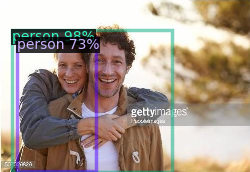

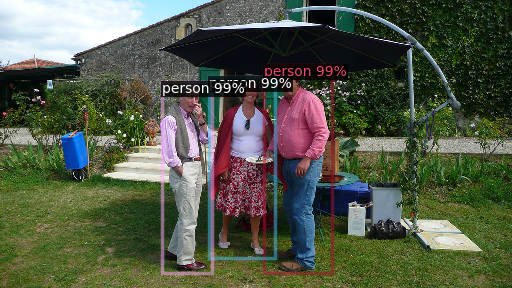

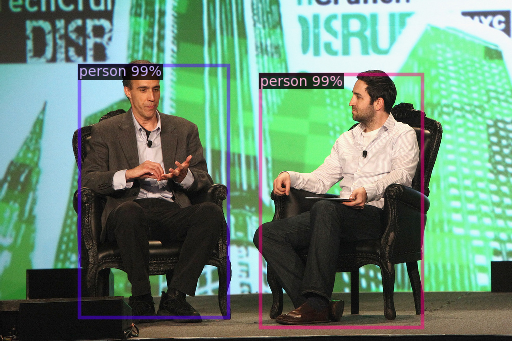

[02/15 19:04:14 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[02/15 19:04:14 d2.evaluation.coco_evaluation]: Trying to convert 'LVMHPV2_val' to COCO format ...
[02/15 19:04:14 d2.data.datasets.coco]: Converting annotations of dataset 'LVMHPV2_val' to COCO format ...)
4999
[02/15 19:04:40 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/15 19:04:42 d2.data.datasets.coco]: Conversion finished, #images: 4999, #annotations: 13257
[02/15 19:04:42 d2.data.datasets.coco]: Caching COCO format annotations at './output0/LVMHPV2_val_coco_format.json' ...
4999
[02/15 19:05:08 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   person   | 13257        |
|            |              |
[02/15 19:05:08 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='c

In [ ]:
cfg0.MODEL.WEIGHTS = os.path.join(cfg0.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg0.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg0)

dataset_dicts = get_LVMHPV2_dicts("/content/LV-MHP-v2/val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=LVMHP_meta,
                   scale=0.5,
                   #instance_mode=ColorMode.IMAGE_BW
                   )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])
    cv2.waitKey(0)

evaluator = COCOEvaluator("LVMHPV2_val", output_dir="./output0")
val_loader = build_detection_test_loader(cfg0, "LVMHPV2_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))